# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [73]:
#Import libs
import pandas as pd
import numpy as np
import math
import json
from sklearn.preprocessing import MultiLabelBinarizer
import datetime
import os
import seaborn as sns
import pickle
%matplotlib inline
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 1. Read Dataset

In [47]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 2. Data understanding and cleaning

##### A. Portfolio 

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
portfolio.shape

(10, 6)

In [6]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [7]:
#Check missing Values
print(portfolio.isnull().sum().sum())

0


In [8]:
#check type of offers
portfolio.offer_type.unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [9]:
#check duplicate rows
portfolio[portfolio.duplicated(['id'], keep=False)]

,channels,difficulty,duration,id,offer_type,reward


In [10]:
#Rename col "id" to "offer_id"
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

In [11]:
def encod_portfolio(portfolio):
    '''
    Encoding portfolio data to required format for applying analyses
    
    Input: portfolio data
    
    Output: df_portfolio - encoded data
    
    '''
    df_portfolio = portfolio.copy()
    #encoding channels
    mlb = MultiLabelBinarizer()
    df_portfolio = df_portfolio.join(pd.DataFrame(mlb.fit_transform(df_portfolio.pop('channels')),
                          columns = mlb.classes_,
                          index = df_portfolio.index))
    #encoding offer_type
    offer_type = pd.get_dummies(df_portfolio['offer_type'])
    # drop the offer_type column
    df_portfolio.drop(['offer_type'], axis=1, inplace=True)
    #Transform duration from day to hour
    df_portfolio['duration'] = df_portfolio['duration'] * 24
    # Merge portfolio and offer_type
    df_portfolio = pd.concat([df_portfolio, offer_type], axis=1, sort=False)
    
    return df_portfolio

In [12]:
df_portfolio = encod_portfolio(portfolio)
df_portfolio.head()

,difficulty,duration,offer_id,reward,email,mobile,social,web,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,1,1,1,0,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,0,1,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,0,1,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,0,0,1,0,1,0


#### B. Profile

In [13]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [14]:
profile.shape

(17000, 5)

In [15]:
#Rename col "id" to "customer_id"
profile.rename(columns={'id': 'customer_id'}, inplace=True)

In [16]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [17]:
#check duplicate clients
profile['customer_id'].nunique()

17000

In [18]:
profile.head()

,age,became_member_on,gender,customer_id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


No duplicates are found among customrs clounm

In [19]:
#Check missing values by col
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
customer_id            0
income              2175
dtype: int64

The columns gender and income include missing values. Thus we will proceed by cleaning the data

In [20]:
def profile_clean(profile):
    '''
    Cleaning the profile data
    
    Iuput: profile - data to proceed cleaning
    
    Output: profile - cleaned profile data
    
    '''
    #clean age missing values
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    #drop all missing values
    profile.dropna(inplace=True)

    #change date format in col became_member_on 
    profile.became_member_on = profile['became_member_on'].astype(str).astype('datetime64[ns]', format = "%Y%m%d")
    # add col days_member
    profile['days_member'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['days_member'] = profile['days_member'].dt.days
    

    return profile

In [21]:
df_profile = profile_clean(profile)

In [22]:
df_profile.head()

,age,became_member_on,gender,customer_id,income,days_member
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1414
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1481
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1129
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,1205
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1295


#### C. Transcript

In [69]:
transcript.head(10)

,event,customer_id,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [49]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [50]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [51]:
#Rename col "person" to "customer_id"
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

In [56]:
def transcript_clean(transcript):
    '''
    Cleaning the transcript data
    Iuput: transcript - data to proceed cleaning
    Output: df_offers - cleaned transcript data
    '''
    #extract offer type
    df_offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    # extract the offer id from value column
    df_offer['offer_id'] = df_offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return df_offer

In [57]:
df_offer = transcript_clean(transcript)

In [70]:
df_offer.head()

,event,customer_id,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


### 3. Exploratory Data Analysis

#### A. Profile

In [33]:
df_profile.head()

,age,became_member_on,gender,customer_id,income,days_member
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1414
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1481
5,68.0,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,1129
8,65.0,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,1205
12,58.0,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,1295


##### General Distribution of data in Profile

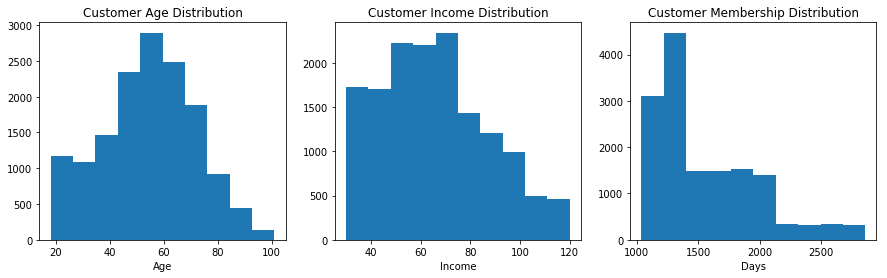

In [34]:
# draw 3 subplots in same row
fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=3)

# plot client age distribution
plt.sca(ax[0])
plt.hist(df_profile['age'])
plt.xlabel('Age')

plt.title('Customer Age Distribution')

# plot client distribution
plt.sca(ax[1])
plt.hist(df_profile['income'] * 1E-3 )
plt.xlabel('Income')
plt.title('Customer Income Distribution');

# plot client membership distribution
plt.sca(ax[2])
plt.hist(df_profile['days_member'])
plt.xlabel('Days')
plt.title('Customer Membership Distribution');

The plot of customer age distribution highlights that the median age of a customer is 60. Furthermore, it can be revelaed that customers age is ranging between 40 to 70 years old. Regarding the customer income distribution, it is highlighted that most of the costumers are with an average salary less than 70K. In addition, the curstomer membership distribution plot pointed out that the membership of customes range between 1000 and 2100 days.

#### B. Portfolio

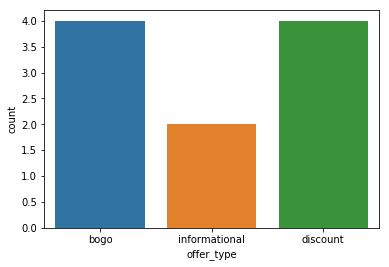

In [59]:
#checking distribution of events in the dataframe
sns.countplot('offer_type', data= portfolio)

The plot highlights that the offers bogo and discount are mainly dominating.

### 4. Modeling: Build Recommendation Engine

#### A. Build User Matrix

In [71]:
def create_user_item_matrix(df_offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    df_offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = df_offer.groupby(['customer_id', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in df_offer[(df_offer['offer_id']==offer_id) & (df_offer['customer_id']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [74]:
df = create_user_item_matrix(df_offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [75]:
df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [76]:
size_train = int(df_offer.shape[0]*0.7)
size_test = df_offer.shape[0] - size_train
size_train, size_test

(117306, 50275)

In [77]:
offer_train = df_offer[:size_train]

In [78]:
offer_test = df_offer[size_train:]

In [79]:
df_train = create_user_item_matrix(offer_train, 'df_train.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [80]:
df_train.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [81]:
df_test = create_user_item_matrix(offer_test, 'df_test.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [82]:
df_test.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [83]:
df = pd.read_pickle('user_item_matrix.p')

In [85]:
df_train = pd.read_pickle('df_train.p')

In [86]:
df_test = pd.read_pickle('df_test.p')

#### B. Implement FunkSVD

In [93]:
#https://medium.datadriveninvestor.com/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac   
#https://towardsdatascience.com/personalised-restaurant-recommendations-using-funksvd-3beff200b01c  


def FunkSVD(user_item_matrix, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    Input:
    user_item_matrix - (numpy array) a matrix with users as rows, offers as columns, and completion as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    Output:
    user_matrix - (numpy array) a user by latent feature matrix
    offer_matrix - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = user_item_matrix.shape[0]
    n_offers = user_item_matrix.shape[1]
    num_offers = np.count_nonzero(~np.isnan(user_item_matrix))
    
    # initialize the user and movie matrices with random values
    user_matrix = np.random.rand(n_users, latent_features)
    offer_matrix = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the offer was completed
                if user_item_matrix[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = user_item_matrix[i, j] - np.dot(user_matrix[i, :], offer_matrix[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_matrix[i, k] += learning_rate * (2*diff*offer_matrix[k, j])
                        offer_matrix[k, j] += learning_rate * (2*diff*user_matrix[i, k])

        # print results for iteration
        print("%d \t\t %f" % (iteration+1, sse_accum / num_offers))
        
    return user_matrix, offer_matrix



In [94]:
# Create user-by-item matrix - nothing to do here
np_train_data = np.array(df_train)

In [95]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_matrix_20, offer_matrix_20 = FunkSVD(np_train_data, latent_features=20, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.087035
2 		 0.030220
3 		 0.028875
4 		 0.028548
5 		 0.028360
6 		 0.028200
7 		 0.028048
8 		 0.027898
9 		 0.027750
10 		 0.027603
11 		 0.027457
12 		 0.027311
13 		 0.027167
14 		 0.027023
15 		 0.026881
16 		 0.026739
17 		 0.026598
18 		 0.026458
19 		 0.026319
20 		 0.026181
21 		 0.026044
22 		 0.025907
23 		 0.025772
24 		 0.025637
25 		 0.025503
26 		 0.025370
27 		 0.025238
28 		 0.025106
29 		 0.024975
30 		 0.024846
31 		 0.024716
32 		 0.024588
33 		 0.024461
34 		 0.024334
35 		 0.024208
36 		 0.024082
37 		 0.023958
38 		 0.023834
39 		 0.023711
40 		 0.023589
41 		 0.023467
42 		 0.023346
43 		 0.023226
44 		 0.023106
45 		 0.022988
46 		 0.022870
47 		 0.022752
48 		 0.022635
49 		 0.022519
50 		 0.022404
51 		 0.022289
52 		 0.022175
53 		 0.022062
54 		 0.021949
55 		 0.021837
56 		 0.021725
57 		 0.021614
58 		 0.021504
59 		 0.021394
60 		 0.021285
61 		 0.021176
62 		 0.021069
63 		 0.020961
64 		 0

In [96]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_matrix_15, offer_matrix_15 = FunkSVD(np_train_data, latent_features=15, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.068025
2 		 0.031165
3 		 0.030202
4 		 0.029888
5 		 0.029660
6 		 0.029449
7 		 0.029243
8 		 0.029040
9 		 0.028838
10 		 0.028639
11 		 0.028442
12 		 0.028246
13 		 0.028053
14 		 0.027860
15 		 0.027670
16 		 0.027481
17 		 0.027294
18 		 0.027109
19 		 0.026925
20 		 0.026743
21 		 0.026563
22 		 0.026384
23 		 0.026207
24 		 0.026031
25 		 0.025857
26 		 0.025684
27 		 0.025513
28 		 0.025343
29 		 0.025175
30 		 0.025008
31 		 0.024843
32 		 0.024679
33 		 0.024516
34 		 0.024355
35 		 0.024196
36 		 0.024038
37 		 0.023881
38 		 0.023725
39 		 0.023571
40 		 0.023418
41 		 0.023266
42 		 0.023116
43 		 0.022967
44 		 0.022819
45 		 0.022673
46 		 0.022528
47 		 0.022384
48 		 0.022241
49 		 0.022099
50 		 0.021959
51 		 0.021820
52 		 0.021682
53 		 0.021545
54 		 0.021409
55 		 0.021274
56 		 0.021141
57 		 0.021009
58 		 0.020877
59 		 0.020747
60 		 0.020618
61 		 0.020490
62 		 0.020363
63 		 0.020237
64 		 0

In [97]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_matrix_10, offer_matrix_10 = FunkSVD(np_train_data, latent_features=10, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.049506
2 		 0.034150
3 		 0.033404
4 		 0.033004
5 		 0.032647
6 		 0.032301
7 		 0.031962
8 		 0.031627
9 		 0.031297
10 		 0.030972
11 		 0.030652
12 		 0.030335
13 		 0.030023
14 		 0.029716
15 		 0.029412
16 		 0.029113
17 		 0.028818
18 		 0.028527
19 		 0.028240
20 		 0.027957
21 		 0.027678
22 		 0.027403
23 		 0.027131
24 		 0.026864
25 		 0.026600
26 		 0.026339
27 		 0.026082
28 		 0.025828
29 		 0.025578
30 		 0.025332
31 		 0.025088
32 		 0.024848
33 		 0.024612
34 		 0.024378
35 		 0.024148
36 		 0.023920
37 		 0.023696
38 		 0.023475
39 		 0.023257
40 		 0.023041
41 		 0.022829
42 		 0.022619
43 		 0.022412
44 		 0.022208
45 		 0.022007
46 		 0.021808
47 		 0.021612
48 		 0.021419
49 		 0.021228
50 		 0.021039
51 		 0.020853
52 		 0.020670
53 		 0.020489
54 		 0.020310
55 		 0.020134
56 		 0.019960
57 		 0.019788
58 		 0.019618
59 		 0.019451
60 		 0.019285
61 		 0.019122
62 		 0.018961
63 		 0.018803
64 		 0

In [98]:
# Fit FunkSVD with the specified hyper parameters to the training data
user_matrix_5, offer_matrix_5 = FunkSVD(np_train_data, latent_features=5, learning_rate=0.005, iters=250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.049851
2 		 0.045655
3 		 0.044428
4 		 0.043423
5 		 0.042477
6 		 0.041563
7 		 0.040677
8 		 0.039814
9 		 0.038975
10 		 0.038159
11 		 0.037364
12 		 0.036591
13 		 0.035838
14 		 0.035106
15 		 0.034393
16 		 0.033699
17 		 0.033024
18 		 0.032367
19 		 0.031727
20 		 0.031105
21 		 0.030498
22 		 0.029908
23 		 0.029334
24 		 0.028775
25 		 0.028230
26 		 0.027700
27 		 0.027184
28 		 0.026681
29 		 0.026192
30 		 0.025715
31 		 0.025251
32 		 0.024798
33 		 0.024358
34 		 0.023929
35 		 0.023510
36 		 0.023103
37 		 0.022706
38 		 0.022319
39 		 0.021942
40 		 0.021575
41 		 0.021217
42 		 0.020868
43 		 0.020528
44 		 0.020196
45 		 0.019873
46 		 0.019558
47 		 0.019251
48 		 0.018951
49 		 0.018659
50 		 0.018374
51 		 0.018095
52 		 0.017824
53 		 0.017560
54 		 0.017302
55 		 0.017050
56 		 0.016804
57 		 0.016564
58 		 0.016330
59 		 0.016102
60 		 0.015879
61 		 0.015661
62 		 0.015449
63 		 0.015241
64 		 0

According to the MSE values, the model with 5 latent featues performs better than 20, 15, and 10 features. This can be ascribed to overfitting. Thus, as a next step, it is required to perform prediction of the test data to validate the results.

#### C. Check FUNKSVD models with test data

In [119]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the df reviews
    offer_id - the offer_id according the df offer
    
    OUTPUT:
    prediction - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        # Use the training data to create a series of users and movies that matches the ordering in training data
        user_ids_series = np.array(df_train.index)
        offer_ids_series = np.array(df_train.columns)

        # User row and Movie Column
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]

        # Take dot product of that row and column in U and V to make prediction
        prediction = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return prediction
    
    except:
        return None

In [120]:
def validation(df_test, user_matrix, offer_matrix):
    '''Measure the squared errors for the prediction'''
    num_complete = np.count_nonzero(~np.isnan(df_test))
    
    sse_accum = 0
    
    for user_id in df_test.index:
        for offer_id in df_test.columns:
            if ~np.isnan(df_test.loc[user_id, offer_id]):
                predict_value = predict_reaction(user_matrix, offer_matrix, user_id, offer_id)
                if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = df_test.loc[user_id, offer_id] - predict_reaction(user_matrix, offer_matrix, user_id, offer_id)

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
    
    print(sse_accum / num_complete)

In [122]:
# Evaluation for latent features of 20
validation(df_test, user_matrix_20, offer_matrix_20)

0.907767556582


In [124]:
# Evaluation for latent features of 15
validation(df_test, user_matrix_15, offer_matrix_15)

0.907527939812


In [125]:
# Evaluation for latent features of 10
validation(df_test, user_matrix_10, offer_matrix_10)

0.917476810067


In [126]:
# Evaluation for latent features of 5
validation(df_test, user_matrix_5, offer_matrix_5)

0.906086489741


The scores obtained after performing the model validation highlights that using latent featues of 5 may lead to better performance.

#### D. Recommendation

The main target is to build a recommendation engine supporting new customers. The engine will recommend offers based on the best sales of offers dedicted to existing customers.

In [148]:
#https://towardsdatascience.com/starbucks-offer-personalization-sending-the-right-offer-to-the-right-customer-14d4fbc20575
# extract best sales offers
def best_sales(user_item_matrix):

    gain_offer = []
    for offer_id in user_item_matrix.columns:
        gain_offer.append([offer_id, transcript[(transcript['customer_id'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(gain_offer, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Comapring Sales of Different Offers')
    best_sale.set_xlabel('Offer')
    best_sale.set_ylabel('Sales')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


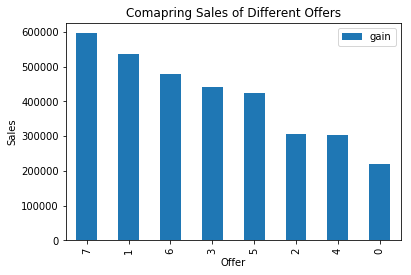

In [149]:
best_sales(df)

In [153]:
def offer_recommendation(user_id, user_matrix, offer_matrix):
    recommendation = {}
    for offer_id in df_train.columns:
        predict_value = predict_reaction(user_matrix, offer_matrix, user_id, offer_id)
        if predict_value != None:
            recommendation[offer_id] = predict_value
        else:
            break
    if predict_value == None:
        print("New Customer, generating top best sales offer for existing customers.")
        best_offer = best_sales(df)
        for offer_id in best_offer['offer_id']:
            print("offer id: ", offer_id)
    else:
        print("Recommended offer for customer number: ", user_id)
        for offer_id, predict_value in sorted(recommendation.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print("offer id: ", offer_id, " predicted value: ", round(predict_value,2))

In [154]:
# recommended offers for an existing customer
offer_recommendation('78afa995795e4d85b5d9ceeca43f5fef', user_matrix_5, offer_matrix_5)

Recommended offer for customer number:  78afa995795e4d85b5d9ceeca43f5fef
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  1.16
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  1.15
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  1.14
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  1.07
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  1.03
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  1.02
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.96
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.95


New Customer, generating top best sales offer for existing customers.
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id:  fafdcd668e3743c1bb461111dcafc2a4
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
offer id:  f19421c1d4aa40978ebb69ca19b0e20d
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
offer id:  ae264e3637204a6fb9bb56bc8210ddfd
offer id:  2906b810c7d4411798c6938adc9daaa5
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


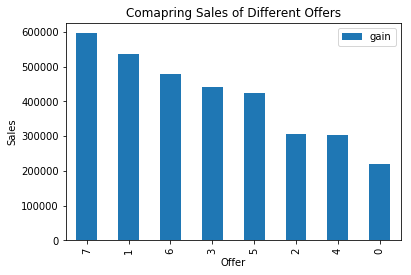

In [155]:
# recommended offers to new customer
offer_recommendation('new_user', user_matrix_5, offer_matrix_5)

### 5. Improve the Recommendation Engine

Further steps can be applied to enhance the implemented recommendation engine including for example: 
  - Taking into consideration the customer profile such as age, gender, incomes
  - Applying further algorithms



### 6. References and Acknowledgement
- Ref1. The dataste is provided by Starbucks
- Ref2. Thank you Udacity for guiding with knowledge building.
- Ref3. Implementing Recommendation Engine for Sturbucks [Andrea Xue](https://towardsdatascience.com/starbucks-offer-personalization-sending-the-right-offer-to-the-right-customer-14d4fbc20575)
- Ref4. Implementing FunkSVD [Medhy Vinceslas](https://medium.datadriveninvestor.com/how-funk-singular-value-decomposition-algorithm-work-in-recommendation-engines-36f2fbf62cac) and [Paul Stubley](https://towardsdatascience.com/personalised-restaurant-recommendations-using-funksvd-3beff200b01c )
- Ref5. The Medium Blog of [Joshua Yeung](https://medium.com/@joshua.chyeung/send-out-a-starbucks-offer-that-you-cannot-resist-2d4d7d18b417) guided me a lot with understanding steps to implement the recommendation engine using Starbucks data. Thank you for sharing your valuable knowledge. 